<a href="https://colab.research.google.com/github/EmicoBinsfinder/GNN_Viscosity_Prediction/blob/main/DynamicViscosityPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN (Convolution and Attention Based) for Molecular Property Prediction (Regression)

* Google Colab
* RDKit
* PyTorch Geometric (PyG)

## Environment Preparation

instal rdkit and pyg

In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.7 MB/s eta 0:00:00


In [2]:
import torch
pyg_url = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $pyg_url

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=28e86060b43154d467d546ee82d4594faeec3636a212982ea5aded3a6d264848
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [3]:
!git clone https://github.com/EmicoBinsfinder/GNN_Viscosity_Prediction.git

Cloning into 'GNN_Viscosity_Prediction'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 41 (delta 8), reused 31 (delta 5), pack-reused 0
Receiving objects: 100% (41/41), 6.71 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (8/8), done.


import

In [4]:
import sys
import urllib.request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx


In [5]:
!curl -O https://raw.githubusercontent.com/itakigawa/mpl_rdkit_utils/main/mpl_rdkit_utils.py

from mpl_rdkit_utils import DrawMolToMPL

def plot_mol_graph(graph, figsize=(8, 4), edge_label=True):
  g = to_networkx(graph, to_undirected=True)
  edge_dict = defaultdict(list)
  for i, e in enumerate(zip(*graph.edge_index.tolist())):
    u, v = e
    edge_dict[(u, v)].append(i)
    edge_dict[(v, u)].append(i)
  labels = {e: "{},{}".format(*edge_dict[e]) for e in g.edges}

  mol = graph.mol
  AllChem.Compute2DCoords(mol)
  pos = mol.GetConformers()[0].GetPositions()[:,:2]

  fig, ax = plt.subplots(1, 2, figsize=figsize)
  node_size=300
  nx.draw_networkx(g, pos, ax=ax[0], node_color='#eee', \
                   node_size=node_size, edgecolors='k')
  if edge_label:
    nx.draw_networkx_edge_labels(g, pos, ax=ax[0], edge_labels=labels,\
                                font_color='blue', rotate=False)
  dpi = plt.rcParams["figure.dpi"]
  node_radius = (node_size / 3.14159265359)**0.5 / dpi
  ax[0].set_axis_off()
  ax[0].set_aspect('equal')
  xmin, xmax = ax[0].get_xlim()
  ymin, ymax = ax[0].get_ylim()
  fs = min(*figsize)
  xr = node_radius * fs
  yr = node_radius * fs
  ax[0].set_xlim(xmin-xr, xmax+xr)
  ax[0].set_ylim(ymin-yr, ymax+yr)

  (xmin, xmax), (ymin, ymax) = DrawMolToMPL(mol, fig, ax[1])
  ax[1].set_xlim(xmin, xmax)
  ax[1].set_ylim(ymin, ymax)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7540  100  7540    0     0  22306      0 --:--:-- --:--:-- --:--:-- 22440


# data loading

In [6]:
# Read in dataset from CSV file
df = pd.read_csv('/content/GNN_Viscosity_Prediction/Dataset.csv')

In [7]:
# Generating a list of number to assign IDs to each entry
ID_list = list(range(len(df)))
df['ID'] = ID_list

#Making dataframe with only target property and molecule ID
df = df[['smiles', 'ID', 'VI']]

#Removing entries with Viscosity Index of less than Zero
df = df.loc[df['VI'] > 0]

#Removing duplicates and entries with NaNs
df = df.dropna()
df = df.drop_duplicates()

#Shuffle Dataset
df = df.sample(frac=1).reset_index(drop=True)

#Creating new CSV with target variable and it's SMILES string
df.to_csv('input.csv')

In [8]:
df.head()
len(df)

47534

In [9]:
# Reading in new Dataset
df = pd.read_csv('input.csv', index_col=0)

#Selecting random entry from Dataset
smi = df['smiles'][9314]

#Constructs a molecule object from a given SMILES string
mol = Chem.MolFromSmiles(smi)
print(type(mol))

<class 'rdkit.Chem.rdchem.Mol'>


In [10]:
smi

'C(c1ccccc1)(C=CC1CCCCC1)C=CCCC=CC1CCCCC1'

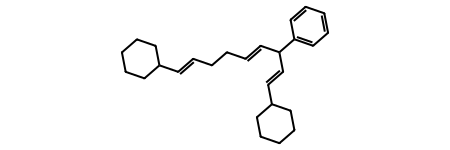

In [11]:
# Display plot of the SMILES string of a random entry from the dataset
mol

# molecular graphs for pyg

In [12]:
edges = []

"""
The mol object assigns index values to every atom in the SMILES string (verify)

The mol object also has a bond object where each bond is connected to two atom
indexes. Each bond has a unique pair of indexes that it is attached to.

So we can generate a list of bonds between each atom by creating tuple of these
unique bonds pairs
"""

for bond in mol.GetBonds():
  #Returns the index of the bond’s first atom
  i = bond.GetBeginAtomIdx()

  #Returns the index of the bond’s last atom
  j = bond.GetEndAtomIdx()

  #Add bonds (edges) to empty list as a list of bond tuples
  edges.extend([(i,j), (j,i)])

In [13]:
edge_index = list(zip(*edges))

In [14]:
def atom_feature(atom):
  return [atom.GetAtomicNum(),
          atom.GetDegree(),
          atom.GetNumImplicitHs(),
          atom.GetIsAromatic()]

def bond_feature(bond):
  return [bond.GetBondType(),
          bond.GetStereo()]

In [15]:
node_features = [atom_feature(a) for a in mol.GetAtoms()]
edge_features = [bond_feature(b) for b in mol.GetBonds()]

In [16]:
g = Data(edge_index=torch.LongTensor(edge_index),
         x=torch.FloatTensor(node_features),
         edge_attr=torch.FloatTensor(edge_features),
         smiles=smi,
         mol=mol)

In [17]:
g

Data(x=[27, 4], edge_index=[2, 58], edge_attr=[29, 2], smiles='C(c1ccccc1)(C=CC1CCCCC1)C=CCCC=CC1CCCCC1', mol=<rdkit.Chem.rdchem.Mol object at 0x7a5900505b60>)

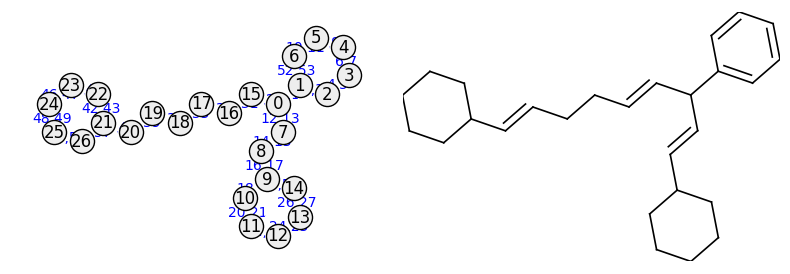

In [18]:
plot_mol_graph(g)

In [19]:
def smi_to_pyg(smi, y):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
      return None

    id_pairs = ((b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds())
    atom_pairs = [z for (i, j) in id_pairs for z in ((i, j), (j, i))]

    bonds = (mol.GetBondBetweenAtoms(i, j) for (i, j) in atom_pairs)
    atom_features = [atom_feature(a) for a in mol.GetAtoms()]
    bond_features = [bond_feature(b) for b in bonds]

    return Data(edge_index=torch.LongTensor(list(zip(*atom_pairs))),
                x=torch.FloatTensor(atom_features),
                edge_attr=torch.FloatTensor(bond_features),
                y=torch.LongTensor([y]),
                mol=mol,
                smiles=smi)

In [20]:
class MyDataset(Dataset):
  def __init__(self, smiles, response):
    mols = [smi_to_pyg(smi, y) for smi, y in \
            tqdm(zip(smiles, response), total=len(smiles))]
    self.X = [m for m in mols if m]

  def __getitem__(self, idx):
    return self.X[idx]

  def __len__(self):
    return len(self.X)

In [21]:
base_dataset = MyDataset(df['smiles'], df['VI'])

  0%|          | 0/47534 [00:00<?, ?it/s]

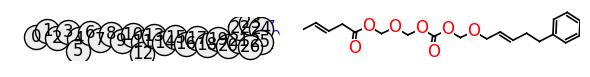

In [22]:
g = base_dataset[820]
plot_mol_graph(g, figsize=(6, 3), edge_label=True)

In [23]:
g

Data(x=[27, 4], edge_index=[2, 54], edge_attr=[54, 2], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7a58f7907d80>, smiles='CC=CCC(=O)OCOCOC(=O)OCOCC=CCCc1ccccc1')

In [24]:
g.y

tensor([46])

# train/val/test split

In [25]:
N = len(base_dataset)
M = N // 10

indices = np.random.permutation(range(N))

idx = {'train': indices[:8*M],
      'valid': indices[8*M:9*M],
      'test': indices[9*M:]}

modes = ['train', 'valid', 'test']

In [26]:
dataset = {m: Subset(base_dataset, idx[m]) for m in modes}


loader = {m: DataLoader(dataset[m], batch_size=64, shuffle=True) if m == 'train' \
          else DataLoader(dataset[m], batch_size=64) for m in modes}

# gin & gatv2 with edge_attr

In [27]:
from torch_geometric.nn import GINEConv, GATv2Conv, global_add_pool

In [28]:
def MyConv(node_dim, edge_dim, arch='GAT'):
  conv = None
  if arch == 'GIN':
    h = nn.Sequential(nn.Linear(node_dim, node_dim, bias=True))
    conv = GINEConv(h, edge_dim=edge_dim)
  elif arch == 'GAT':
    conv = GATv2Conv(node_dim, node_dim, edge_dim=edge_dim)
  return conv

In [29]:
class MyGNN(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3):
    super().__init__()
    layers = [MyConv(node_dim, edge_dim, arch) for _ in range(num_layers)]
    self.convs = nn.ModuleList(layers)

  def forward(self, x, edge_index, edge_attr):
    for conv in self.convs:
      x = conv(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
    return x

In [30]:
[int(x) for x in Chem.rdchem.BondType.names.values()]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [31]:
ptable = Chem.GetPeriodicTable()
for i in range(200):
  try:
    s = ptable.GetElementSymbol(i)
  except:
    print(f'max id {i-1} for {s}')
    break
ptable.GetElementSymbol(i-1)

max id 118 for Og


[16:12:17] 

****
Pre-condition Violation
Atomic number not found
Violation occurred on line 99 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/PeriodicTable.h
Failed Expression: atomicNumber < byanum.size()
****



'Og'

In [32]:
class MyFinalNetwork(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3,
               encoding='onehot'):
    super().__init__()

    self.encoding = encoding
    if encoding != 'onehot':
      self.atom_encoder = nn.Embedding(num_embeddings=118+1, embedding_dim=64)
      self.bond_encoder = nn.Embedding(num_embeddings=21+1, embedding_dim=8)
      node_dim = (node_dim-1) + 64
      edge_dim = (edge_dim-1) + 8
    else:
      node_dim = (node_dim-1) + 118+1
      edge_dim = (edge_dim-1) + 21+1

    self.gnn = MyGNN(node_dim, edge_dim, arch, num_layers=num_layers)
    embed_dim = int(node_dim / 2)
    self.head = nn.Sequential(
        nn.BatchNorm1d(node_dim),
        nn.Dropout(p=0.5),
        nn.Linear(node_dim, embed_dim, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(embed_dim),
        nn.Dropout(p=0.5),
        nn.Linear(embed_dim, 1)
    )
  def forward(self, x, edge_index, edge_attr, batch):
    if self.encoding == 'onehot':
      x0 = F.one_hot(x[:, 0].to(torch.int64), num_classes=118+1)
      edge_attr0 = F.one_hot(edge_attr[:, 0].to(torch.int64), num_classes=21+1)
    else:
      x0 = self.atom_encoder(x[:, 0].int())
      edge_attr0 = self.bond_encoder(edge_attr[:, 0].int())

    x = torch.cat([x0, x[:, 1:]], dim=1)
    edge_attr = torch.cat([edge_attr0, edge_attr[:, 1:]], dim=1)

    node_out = self.gnn(x, edge_index, edge_attr)
    graph_out = global_add_pool(node_out, batch)
    return self.head(graph_out)

In [33]:
node_dim = base_dataset[0].num_node_features
edge_dim = base_dataset[0].num_edge_features
node_dim, edge_dim

(4, 2)

In [38]:
model = MyFinalNetwork(node_dim, edge_dim, arch='GAT', num_layers=3, encoding='embedding')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [39]:
train_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.L1Loss()

## Pytorch Traning Pipeline

In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropagation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. This accumulating behavior is convenient while training RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches. So, the default action has been set to accumulate (i.e. sum) the gradients on every loss.backward() call.

Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

In [40]:
def train(loader):
    total_loss = total_examples = 0
    for data in loader:

        #Moving data to inference device in preparation for inference
        data = data.to(device)

        #Sets the gradients of all optimized torch.Tensors to zero to prepare
        #For next training iteration
        optimizer.zero_grad()

        #Perform transform
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)

        #Calculate loss based on predefined Criterion (in this case MAE)
        loss = criterion(out, data.y.unsqueeze(1).float())

        #Perform backpropagation
        loss.backward()

        #Perfom optimiser update
        optimizer.step()

        #Changes the learning rate depending on the learning rate pre-condition
        scheduler.step()


        total_loss += loss.item()

        #Calculating loss per epoch or per batch (?)
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def test(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.unsqueeze(1).float())
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        _, predicted = torch.max(out.data, 1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [41]:
best_val = float("inf")

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
        ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 001 Loss: train 1.970938 valid 1.957572 test 1.942370
Epoch: 002 Loss: train 1.847092 valid 1.736347 test 1.719969
Epoch: 003 Loss: train 1.492548 valid 1.223861 test 1.208784
Epoch: 004 Loss: train 0.815478 valid 0.466266 test 0.459125
Epoch: 005 Loss: train 0.394145 valid 0.386680 test 0.382117
Epoch: 006 Loss: train 0.372771 valid 0.371220 test 0.370672
Epoch: 007 Loss: train 0.370503 valid 0.373870 test 0.370628
Epoch: 008 Loss: train 0.367895 valid 0.370615 test 0.367742
Epoch: 009 Loss: train 0.364838 valid 0.373634 test 0.371379
Epoch: 010 Loss: train 0.362847 valid 0.360340 test 0.369916
Epoch: 011 Loss: train 0.361621 valid 0.367682 test 0.361165
Epoch: 012 Loss: train 0.360249 valid 0.359494 test 0.362041
Epoch: 013 Loss: train 0.360981 valid 0.363382 test 0.357337
Epoch: 014 Loss: train 0.357040 valid 0.351090 test 0.353630
Epoch: 015 Loss: train 0.354370 valid 0.357063 test 0.364046
Epoch: 016 Loss: train 0.353146 valid 0.356323 test 0.350997
Epoch: 017 Loss: train 0

## Plotting the Loss Curves

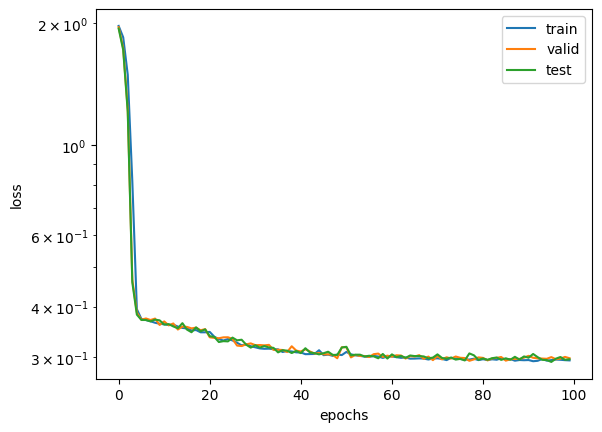

In [42]:
fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [43]:
@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        predicted = out
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [45]:
model.load_state_dict(torch.load('best_val.model'))
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

y_true, y_pred = predict(loader[m])
print(y_true, y_pred)

for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  print(y_pred)
  for metric in [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))

[150, 155, 157, 136, 141, 205, 133, 99, 82, 152, 124, 57, 122, 159, 88, 72, 107, 115, 187, 120, 120, 162, 170, 81, 69, 155, 138, 145, 180, 115, 22, 167, 151, 152, 131, 48, 147, 164, 132, 103, 146, 72, 175, 69, 143, 146, 134, 126, 153, 168, 84, 62, 107, 142, 175, 136, 160, 92, 173, 139, 182, 50, 118, 153, 180, 73, 191, 47, 98, 173, 94, 157, 39, 138, 168, 131, 149, 109, 114, 155, 132, 155, 154, 149, 129, 118, 148, 59, 158, 167, 135, 145, 96, 87, 123, 175, 133, 68, 157, 96, 177, 140, 126, 116, 54, 123, 90, 134, 106, 130, 162, 124, 155, 133, 163, 159, 114, 156, 163, 159, 83, 158, 125, 128, 120, 97, 126, 96, 98, 171, 181, 141, 61, 190, 123, 158, 132, 130, 121, 39, 146, 98, 144, 51, 151, 104, 64, 158, 110, 97, 167, 92, 150, 91, 162, 137, 118, 117, 131, 183, 166, 145, 76, 185, 171, 129, 129, 103, 131, 125, 143, 94, 133, 146, 154, 146, 116, 161, 147, 184, 68, 64, 163, 159, 113, 98, 115, 164, 99, 76, 130, 146, 116, 81, 83, 127, 142, 120, 150, 159, 159, 163, 139, 129, 191, 137, 155, 172, 172, 14